# CNN Architectures

## Librairies

In [1]:
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
print("Tensorflow:",tf.__version__)
print("GPU list:",tf.config.list_physical_devices('GPU'))
from tensorflow.keras import datasets, layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.optimizers import Adam
import datetime



2024-05-27 21:37:00.577357: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 21:37:00.600611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 21:37:00.949309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow: 2.16.1
GPU list: []


2024-05-27 21:37:01.183617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 21:37:01.183810: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Functions

In [2]:

def confusion_matrix_plot(y_true, y_pred, file_save="",labels=[], size=8, fz=15):
    
    cf_matrix = confusion_matrix(y_true, y_pred, normalize=("true"))
    cf_matrix_v = confusion_matrix(y_true, y_pred)
    
    if (len(labels)==0):
        labels = np.unique(y_true)
        print(labels)
    
    # Define a color map for the heatmap
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    plt.figure(figsize = (size,size))
    heatmap = sns.heatmap(cf_matrix, annot=False, cmap=cmap, fmt='d', xticklabels=labels, yticklabels=labels, square=True, cbar=True)
    # heatmap = sns.heatmap(data, annot=False, fmt='d', cmap=cmap)
    
    # Calculate and display percentages
    for i in range(len(cf_matrix)):
        for j in range(len(cf_matrix[i])):
            text = f"{cf_matrix[i][j]*100: 0.2f}% ({cf_matrix_v[i][j]})"
            
            # Calculate the background color at the center of the cell
            cell_bg_color = np.mean(cmap(cf_matrix[i][j]))
            print(i,j, cell_bg_color)
            # Choose a text color based on the background color
            text_color = 'black' if cell_bg_color > 0.7 else 'white'
                    
            heatmap.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color)
    
    # ax.set_xticklabels(ax.get_xticklabels(),rotation = 40)
    # ax.set_yticklabels(ax.get_xticklabels(),rotation = 40)
    

    plt.title("Confusion Matrix",fontsize=fz)
    plt.xlabel("Predicted",fontsize=fz-2)
    plt.ylabel("Real",fontsize=fz-2)
    
    plt.tight_layout()
    
    if(file_save!=""):
        plt.savefig(file_save)
    
    plt.show()
    
    return cf_matrix


def load_images(db_path):

    ## List images from dataset ##
    image_file_list = os.listdir(db_path)

    ## Lists to save information ##
    img_list = []
    label_list = []

    for file in image_file_list:

        #### Load-pre-process-save images ####
        ## Create image file ##
        image_file = os.path.join(db_path, file)
        ## Load image ##
        img = cv2.imread(image_file)
        ## Tranform to gray sacale ##
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC) 
        ## Reshape the image to (W, H, C) ##
        H, W = img.shape
        img = img.reshape(W, H, 1)
        ## Normalize pixels to [0,1] ##
        img = np.float64(img)/255.0
        ## Invert image pixels ##
        img = (1.0 - img)
        ## save image in list ##
        img_list.append(img)
        #######################################

        #### Assign labels ####
        if("PD_" in file):
            label_list.append(1)
        else:
            label_list.append(0)
        #######################

    ## Conver images to array object ##
    img_arr = np.asarray(img_list)
    ## Conver label to array object ##
    label_arr = np.asarray(label_list)

    print(img_arr.shape, type(img_arr))
    print(label_arr.shape, type(label_arr))

    return img_arr, label_arr



def split_data(X, y):

    #### Codify labels to onehot ####
    num_classes = len(np.unique(y))
    

    #### Split Data ####
    ## Train and test ##
    X_aux, X_test, y_aux, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

    ## Train and val ##
    X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, test_size=0.2, random_state=42)
    
    ## Convert labels to categorical ##
    y_train_c = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_c = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_c = tf.keras.utils.to_categorical(y_test, num_classes)

    values, counts = np.unique(y_aux, return_counts=True)
    print(f"Aux data {X_aux.shape}, {y_aux.shape}, {counts}")

    values, counts = np.unique(y_train, return_counts=True)
    print(f"Train data {X_train.shape}, {y_train_c.shape}, {counts}")

    values, counts = np.unique(y_val, return_counts=True)
    print(f"Valid data {X_val.shape}, {y_val_c.shape}, {counts}")

    values, counts = np.unique(y_test, return_counts=True)
    print(f"Test data {X_test.shape}, {y_test_c.shape}, {counts}")

    idx = np.random.randint(0, len(y_train_c))
    print_image(X_train[idx], title=f"lab:{y_train_c[idx]}")

    return X_train, y_train_c, X_val, y_val_c, X_test, y_test_c

def print_image(img, title="Image"):
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap="gray")
    plt.title(title)
    # plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.show()


def create_dir(path):

    dirs = path.split("/")
    n_path = ""
    for i in range(len(dirs)):
        
        n_path = os.path.join(n_path, dirs[i])
        # print(n_path)
        a = os.path.isdir(n_path)   
        # print(a) 
        if(not(a)):
            os.mkdir(n_path) 


# plot accuracy and loss
def plotgraph(epochs, train, val, ax, plot, title):
    # Plot training & validation accuracy values
    ax[plot].plot(epochs, train, 'b')
    ax[plot].plot(epochs, val, 'r')
    ax[plot].set_title(title)
    #ax[plot].ylabel(title)
    ax[plot].set(xlabel='Epoch', ylabel=title)
    #ax[plot].xlabel('Epoch')
    ax[plot].legend(['Train', 'Val'])

## Load data

(130, 256, 256, 1) <class 'numpy.ndarray'>
(130,) <class 'numpy.ndarray'>
Aux data (104, 256, 256, 1), (104,), [40 64]
Train data (83, 256, 256, 1), (83, 2), [32 51]
Valid data (21, 256, 256, 1), (21, 2), [ 8 13]
Test data (26, 256, 256, 1), (26, 2), [15 11]


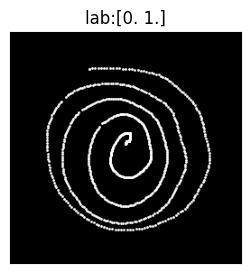

In [21]:
# task_list = ["alphabet", "freewriting", "house", "line1", "name", "rey", "spiral"]

task = "spiral"
dp = 0.8
lr = 1e-7
wd = 1e-4
model_name = "CNN_3_Norm_Drop"

db_path = f"../Dataset/hw_drawings/{task}/"
X, y = load_images(db_path)

X_train, y_train_c, X_val, y_val_c, X_test, y_test_c = split_data(X, y)


## Define model

In [22]:
model = models.Sequential()

# 1st Convolutional Layer
model.add(layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(dp))

# 2nd Convolutional Layer
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(dp))

# 3rd Convolutional Layer
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(dp))

# Flatten and Fully Connected Layer
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(dp))
model.add(layers.Dense(units=2, activation='softmax'))  

model.summary()

/home/gita24/anaconda3/envs/deep/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    14,746,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,753,250 (56.28 MB)

 Trainable params: 14,753,138 (56.28 MB)

 Non-trainable params: 112 (448.00 B)

In [23]:
# model_name = "CNN_3"

# model = models.Sequential()

# model.add(layers.Conv2D(filters=8, kernel_size=(5,5), padding='valid', activation='relu', input_shape=X_train[0].shape))
# model.add(layers.MaxPool2D(strides=2))
# model.add(layers.Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu'))
# model.add(layers.MaxPool2D(strides=2))
# model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu'))
# model.add(layers.MaxPool2D(strides=2))

# #### Capas fully conected ####
# #### Clasification ####
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(2, activation='softmax'))

# model.summary()

## Train model

In [24]:


print("Model Training: ", model_name, "\n\n")

path = f"../Models/{task}/{model_name}/"
create_dir(path)
model_file = f"{path}{model_name}_model.keras"
print(model_file)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr, weight_decay=wd), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=50, verbose=1, mode='min')
mcp_save = ModelCheckpoint(model_file, save_best_only=True, monitor='val_loss', verbose=1, mode='min')


log_dir = f"{path}fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train,
                    y_train_c,
                    epochs=1000,
                    batch_size=6,
                    verbose=1,
                    validation_data=(X_val, y_val_c),
                    callbacks=[early_stopping, mcp_save, tensorboard_callback])


Model Training:  CNN_3_Norm_Drop 


../Models/spiral/CNN_3_Norm_Drop/CNN_3_Norm_Drop_model.keras
Epoch 1/1000


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4570 - loss: 6.8866
Epoch 1: val_loss improved from inf to 0.70668, saving model to ../Models/spiral/CNN_3_Norm_Drop/CNN_3_Norm_Drop_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.4570 - loss: 6.9005 - val_accuracy: 0.3810 - val_loss: 0.7067
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5876 - loss: 5.7995
Epoch 2: val_loss did not improve from 0.70668
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5877 - loss: 5.7785 - val_accuracy: 0.3810 - val_loss: 0.7099
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4039 - loss: 9.5452
Epoch 3: val_loss did not improve from 0.70668
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4067 - loss: 9.4124 - val_accuracy: 0.3810 - val_loss: 0.7128
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5865 - loss: 5.0088
Epoch 4: val_loss did not improve from 0.70668
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy

## Tensorboard

In [25]:
# %load_ext tensorboard
# %tensorboard --logdir "../Models/alphabet/CNN_3_Norm_Drop/CNN_3_Norm_Drop_model/fit"

## History

In [26]:
history_file = f"{path}history_{model_name}.picl"
with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
file_pi.close()

In [27]:
with open(history_file, 'rb') as file_pi:
  history = pickle.load(file_pi)
file_pi.close()

pd.DataFrame.from_dict(history)

,accuracy,loss,val_accuracy,val_loss
0,0.457831,7.094322,0.380952,0.706678
1,0.590361,5.483924,0.380952,0.709924
2,0.445783,7.552872,0.380952,0.712758
3,0.578313,5.118749,0.380952,0.715581
4,0.493976,7.316560,0.380952,0.718031
5,0.590361,6.886834,0.380952,0.719918
6,0.493976,4.544408,0.380952,0.721499
7,0.518072,7.318727,0.380952,0.722795
8,0.662651,4.573659,0.380952,0.723865
9,0.506024,5.126262,0.380952,0.724715


## Training curves

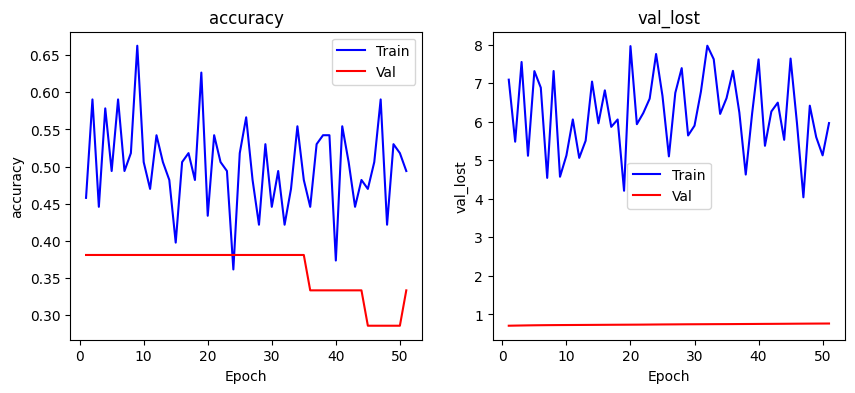

In [28]:

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1,len(acc)+1)


#### crear subplot ####
fig, ax = plt.subplots(1, 2, figsize=(10,4))
#### graficar curva acc ###
plotgraph(epochs, acc, val_acc, ax, 0, "accuracy")
#### graficar curva lost ###
plotgraph(epochs, loss, val_loss, ax, 1, "val_lost")
plt.show()


## Test Model

In [29]:
path = f"../Models/{task}/{model_name}/"
model_file = f"{path}{model_name}_model.keras"
print(model_file)

model = models.load_model(model_file)
model.summary()

../Models/spiral/CNN_3_Norm_Drop/CNN_3_Norm_Drop_model.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    14,746,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,259,528 (168.84 MB)

 Trainable params: 14,753,138 (56.28 MB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 29,506,278 (112.56 MB)

In [30]:
model.evaluate(X_train, y_train_c)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3959 - loss: 0.7085 


[0.710196852684021, 0.3855421543121338]

In [31]:
model.evaluate(X_val, y_val_c)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3810 - loss: 0.7067


[0.7066779136657715, 0.380952388048172]

In [32]:
model.evaluate(X_test, y_test_c)
y_pred_c = model.predict(X_test)
y_pred = y_pred_c.argmax(axis=1)
y_true = y_test_c.argmax(axis=1)
print(y_true.shape, y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5769 - loss: 0.6824


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(26,) (26,)


## Report

In [33]:
#### Mostrar la microclasificación ####
label_dictionary = {
    0: "HC",
    1: "PD"

}
report = classification_report(y_true, y_pred, digits=4, output_dict=False, target_names=list(label_dictionary.values()))
table_report = classification_report(y_true, y_pred, digits=4, output_dict=True, target_names=list(label_dictionary.values()))
table_report = pd.DataFrame.from_dict(table_report).T
print(report)


              precision    recall  f1-score   support

          HC     0.5769    1.0000    0.7317        15
          PD     0.0000    0.0000    0.0000        11

    accuracy                         0.5769        26
   macro avg     0.2885    0.5000    0.3659        26
weighted avg     0.3328    0.5769    0.4221        26



/home/gita24/anaconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gita24/anaconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gita24/anaconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

## Confusion Matrix

0 0 0.40980392156862744
0 1 0.9882352941176471
1 0 0.40980392156862744
1 1 0.9882352941176471


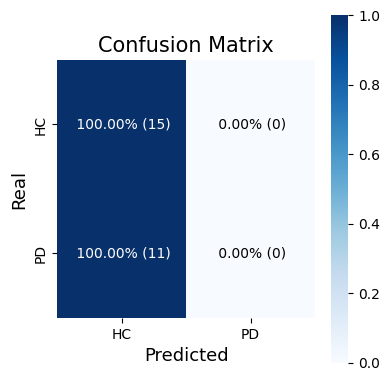

array([[1., 0.],
       [1., 0.]])

In [34]:
labels = list(label_dictionary.values())
file_save = f"{path}CM_{model_name}.pdf"
confusion_matrix_plot(y_true, y_pred, file_save,labels=labels, size=4, fz=15)


In [35]:
df = pd.DataFrame([])
df["y_true"] = y_true
df["y_pred"] = y_pred
df


,y_true,y_pred
0,0,0
1,0,0
2,1,0
3,0,0
4,1,0
5,0,0
6,1,0
7,0,0
8,1,0
9,0,0
